In [1]:
import xarray as xr
import numpy as np
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cmocean

import sys
sys.path.insert(0,'../pyicon-master/') 
import pyicon as pyic

In [1]:
### averages over the last 50 years of the experiment and control runs were calculated with CDO ymonmean and timmean
### CDO setgrid was used to incorporate horizontal grid information from the ICON grid files (icon_grid_0030_R02B03_G.nc, icon_grid_0036_R02B04_O.nc).
### Thesewere retrieved from the URLs given in the output data:
### http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0030/icon_grid_0030_R02B03_G.nc  
### http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0036/icon_grid_0036_R02B04_O.nc

In [2]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    ### https://gist.github.com/aaronspring/fd54970f71a39e26ab54a8b47170533d
    import numpy as np
    #ds.coords.compute()
    with xr.set_options(keep_attrs=True):
        for c in ds.coords:
            if 'units' in ds[c].attrs:
                if ds[c].attrs['units'] == 'radian':
                    # print(f'convert {c} from rad to deg')
                    ds[c] = ds[c]* 180./np.pi
                    ds[c].attrs['units'] = 'degrees'
            elif 'bnds' in c:
                # print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
    return ds

# grid_1deg = xe.util.grid_global(1,1)
grid_1deg = xr.Dataset(
    {"lat": (["lat"], np.arange(-89.5, 89.5+1, 1.)),
     "lon": (["lon"], np.arange(-179.5, 179.5+1, 1.)),
     "lat_b": (["lat_b"], np.arange(-90, 90+1, 1.)),
     "lon_b": (["lon_b"], np.arange(-180, 180+1, 1.))})


def regrid_rec(ds_in):
    ds_in=rad_to_deg(ds_in)
    ds_in=ds_in.rename({'clon':'lon','clat':'lat'})
    ds_out=grid_1deg
    ### https://github.com/pangeo-data/xESMF/issues/115
    ### https://gist.github.com/aaronspring/fd54970f71a39e26ab54a8b47170533d
    re = xe.Regridder(ds_in, ds_out, method='nearest_s2d', locstream_in=True)
    ds_re = re(ds_in)
    
    ds_re.attrs=ds_in.attrs
    for vv in ds_re.data_vars:
        ds_re.data_vars[vv].attrs=ds_in.data_vars[vv].attrs
        
    # ds_in.close()
    # del ds_in
    
    return ds_re

In [12]:
ds_atm_2d=xr.open_dataset('./data/sus22F0_atm_2d_ml_last50yrs_setgrid.nc')
ds_atm_2d_ctrl=xr.open_dataset('./data/sus2200_atm_2d_ml_last50yrs_setgrid.nc')
ds_atm_3d_ctrl=xr.open_dataset('./data/sus2200_atm_3d_ml_last50yrs_setgrid.nc')
ds_atm_mon=xr.open_dataset('./data/sus22F0_atm_mon_last50yrs.nc')

ds_lnd_ctrl=xr.open_dataset('./data/sus2200_lnd_basic_ml_last50yrs_setgrid.nc')

ds_oce_ctrl=xr.open_dataset('./data/sus2200_oce_P1M_2d_last50yrs_setgrid.nc')
ds_oce_3D_ctrl=xr.open_dataset('./data/sus2200_oce_P1M_3d_last50yrs_setgrid.nc')
ds_oce_sqr_ctrl=xr.open_dataset('./data/sus2200_oce_P1M_sqr_last50yrs_setgrid.nc')
ds_oce_moc_ctrl=xr.open_dataset('./data/sus2200_oce_P1M_moc_last50yrs.nc')
ds_oce_moc=xr.open_dataset('./data/sus22F0_oce_P1M_moc_last50yrs.nc')

grid_atm=xr.open_dataset('./data/icon_grid_0030_R02B03_G.nc')
grid_ocn=xr.open_dataset('./data/icon_grid_0036_R02B04_O.nc')

/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jan/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: Seri

In [ ]:
ds_atm_2d_regrid=regrid_rec(ds_atm_2d)
ds_atm_2d_ctrl_regrid=regrid_rec(ds_atm_2d_ctrl)
ds_atm_3d_ctrl_regrid=regrid_rec(ds_atm_3d_ctrl)

ds_lnd_ctrl_regrid=regrid_rec(ds_lnd_ctrl)

ds_oce_ctrl_regrid=regrid_rec(ds_oce_ctrl)
ds_oce_3D_ctrl_regrid=regrid_rec(ds_oce_3D_ctrl)
# ds_oce_3D_ctrl_regrid=regrid_rec(ds_oce_3D_ctrl)

/home/jan/miniconda3/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jan/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [3]:
ds_atm_3d_ctrl=xr.open_dataset('./data/sus2200_atm_3d_ml_last50yrs_setgrid.nc')
ds_atm_3d_ctrl_regrid=regrid_rec(ds_atm_3d_ctrl)

/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jan/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jan/miniconda3/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jan/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.

# Forcing Scenario: Flat Earth (removed orography)

In [ ]:
var=ds_oce_3D_ctrl_regrid.rho.isel(time=0) 
depths=(((var>0)*1)*ds_oce_3D_ctrl_regrid.depth).where(var>0)
depths_seafloor=-1*depths.max(dim='depth')

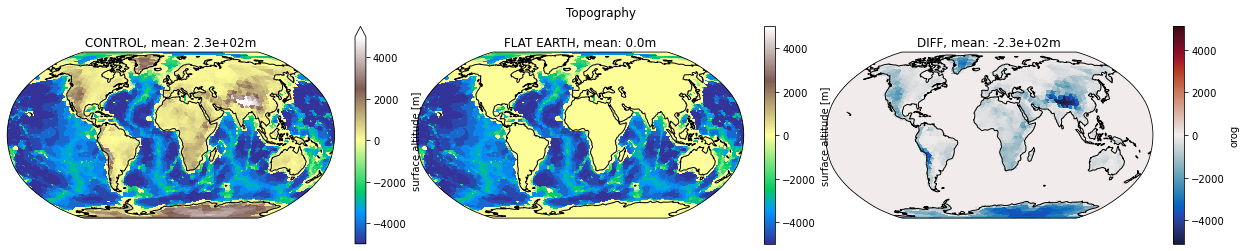

In [92]:
var=ds_atm_2d_regrid.orog
var_ctrl=ds_atm_2d_ctrl_regrid.orog
var_diff=(var-var_ctrl)

vmin=var.min()
vmax=var.max()
if vmin>var_ctrl.min():
    vmin=var_ctrl.min()
if vmax<var_ctrl.max():
    vmax=var_ctrl.max()

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
depths_seafloor.plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=-5000,vmax=5000,cmap='terrain',add_colorbar=False)
var_ctrl.where(var_ctrl>5).plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=-5000,vmax=5000,cmap='terrain') #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
depths_seafloor.plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=-5000,vmax=5000,cmap='terrain',add_colorbar=False)
var.where(var_ctrl>5).plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=-5000,vmax=5000,cmap='terrain')
var_diff.plot(ax=axs[2],transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance) #,vmin=-4,vmax=4

# colors_undersea = plt.cm.terrain(np.linspace(0.1, 0.11, 2)) #plt.cm.terrain(np.linspace(0, 0.17, 56))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200)) #plt.cm.terrain(np.linspace(0.25, 1, 200))
# colors = np.vstack((colors_undersea, colors_land))
# cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)
# fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
# var_ctrl.plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cut_terrain_map) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
# var.plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cut_terrain_map)
# var_diff.plot(ax=axs[2],transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance) #,vmin=-4,vmax=4

for aa in axs:
    aa.coastlines()
    #ax.set_extent([-160, 180, 5, 90])

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

axs[0].set_title('CONTROL, mean: {:.2}m'.format(var_ctrl_mean))
axs[1].set_title('FLAT EARTH, mean: {:.2}m'.format(var_mean))
axs[2].set_title('DIFF, mean: {:+.2}m'.format(var_diff_mean))

fig.suptitle('Topography',y=0.95)
#fig.suptitle('{}'.format(var.attrs['long_name']),y=0.95)

plt.subplots_adjust(wspace=0)

# fig.savefig('../../plots_diff/{}/precipitation.jpg'.format(mm,varname),dpi=200, bbox_inches='tight', pad_inches=0)



# Climatic Effects

## Surface Temperature

## Albedo, Clouds, Sea Ice, Snow

## Atmospheric Circulation, Waves

In [109]:
ds_atm_mon

/home/jan/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.Dataset>
Dimensions:       (time: 1, bnds: 2, lon: 1, lat: 1)
Coordinates:
  * time          (time) object 2325-01-16 11:45:00
  * lon           (lon) float32 0.0
  * lat           (lat) float32 0.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) object ...
    tas_gmean     (time, lat, lon) float32 ...
    rsdt_gmean    (time, lat, lon) float32 ...
    rsut_gmean    (time, lat, lon) float32 ...
    rlut_gmean    (time, lat, lon) float32 ...
    radtop_gmean  (time, lat, lon) float32 ...
    prec_gmean    (time, lat, lon) float32 ...
    evap_gmean    (time, lat, lon) float32 ...
    fwfoce_gmean  (time, lat, lon) float32 ...
    co2_mass      (time, lat, lon) float32 ...
    co2_gmean     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       git@gitlab.dkrz.de:icon/icon-les.git@4ea9f3495f36d16a072059...
    institution:  Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title:        ICON simulation
    history:      Sun Sep 25 14:50:03 2022: cdo timmean -cat sus22F0_atm_mon_...
    references:   see MPIM/DWD publications
    comment:      v174 Workshop (k206174) on l30111 (Linux 4.18.0-305.25.1.el...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Ocean salinity, Overturning

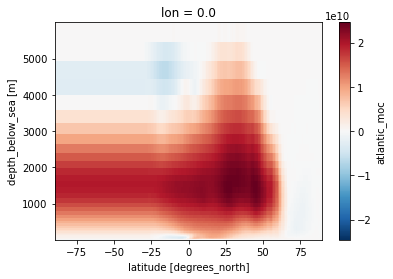

In [107]:
ds_oce_moc_ctrl.atlantic_moc.mean(dim='time').plot()

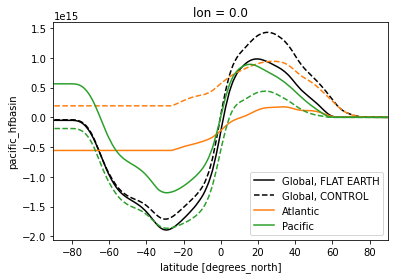

In [9]:
fig,ax=plt.subplots(1,1)

ds_oce_moc.global_hfbasin.mean(dim='time').plot(ax=ax,c='k',label='Global, FLAT EARTH')
ds_oce_moc_ctrl.global_hfbasin.mean(dim='time').plot(ax=ax,c='k',ls='--',label='Global, CONTROL')

ds_oce_moc_ctrl.atlantic_hfbasin.mean(dim='time').plot(ax=ax,c='tab:orange',ls='--')
ds_oce_moc.atlantic_hfbasin.mean(dim='time').plot(ax=ax,c='tab:orange',label='Atlantic')

ds_oce_moc_ctrl.pacific_hfbasin.mean(dim='time').plot(ax=ax,c='tab:green',ls='--')
ds_oce_moc.pacific_hfbasin.mean(dim='time').plot(ax=ax,c='tab:green',label='Pacific')

ax.set_xlim([-90,90])

ax.legend()

## Vegetation

In [2]:
modules=['atm_2d_ml','atm_3d_ml','atm_mon','lnd_basic_ml','lnd_mon','oce_mon','oce_P1M_3d','oce_P1M_moc','oce_P1M_sqr']

vars_sel=['pr']

for mm in [modules[0]]:
    
    ds=     xr.open_dataset('/work/mh1049/k206174/icon-easyms/ensemble_mean_regrided/sus22F0_1deg_{}_50yrsmean.nc'.format(mm))
    ds_ctrl=xr.open_dataset('/work/mh1049/k206174/icon-easyms/ensemble_mean_regrided/sus2200_1deg_{}_50yrsmean.nc'.format(mm))    
    print(mm)

    for varname, da in ds.data_vars.items():         
        if varname in vars_sel:


            var=ds.data_vars[varname]*60*60*24
            var_ctrl=ds_ctrl.data_vars[varname]*60*60*24 #.mean(dim='time')
            if 'height' in var.coords:
                var=var.isel(height=0)
                var_ctrl=var_ctrl.isel(height=0)
            if 'depth' in var.coords:
                var=var.isel(depth=0)
                var_ctrl=var_ctrl.isel(depth=0)
            if 'time' in var.coords:
                var=var.isel(time=0)
                var_ctrl=var_ctrl.isel(time=0)
            var_diff=var-var_ctrl
            var_diff.attrs=ds.data_vars[varname].attrs
            var.attrs=ds.data_vars[varname].attrs
            var_ctrl.attrs=ds.data_vars[varname].attrs

            vmin=var.min()
            vmax=var.max()
            if vmin>var_ctrl.min():
                vmin=var_ctrl.min()
            if vmax<var_ctrl.max():
                vmax=var_ctrl.max()

            if 'lat' in var.coords and 'lon' in var.coords:
                fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
                var.plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax ,cmap=cmocean.cm.rain) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_ctrl.plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax ,cmap=cmocean.cm.rain) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_diff.plot(ax=axs[2],transform=ccrs.PlateCarree(),vmin=-4,vmax=4,cmap=cmocean.cm.balance) #,vmin=-1e3,vmax=1e3,cmap='RdBu'
                for aa in axs:
                    aa.coastlines()
                    #ax.set_extent([-160, 180, 5, 90])

                weights = np.cos(np.deg2rad(var.lat))
                var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
                var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
                var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

                axs[0].set_title('CONTROL, mean: {:.2} mm/d'.format(var_ctrl_mean))
                axs[1].set_title('FLAT EARTH, mean: {:.2} mm/d'.format(var_mean))
                axs[2].set_title('DIFF, mean: {:+.2} mm/d'.format(var_diff_mean))

            else:
                fig,axs=plt.subplots(1,3,figsize=[22,5])
                var.plot(ax=axs[1]) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_ctrl.plot(ax=axs[0]) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_diff.plot(ax=axs[2]) #,vmin=-1e3,vmax=1e3,cmap='RdBu'

            if 'long_name' in var.attrs:        
                fig.suptitle('{}'.format(var.attrs['long_name']),y=0.95)
                print('    {}, {}'.format(varname,var.attrs['long_name']))
            else:
                fig.suptitle('{}'.format(varname),y=0.95)
                print('    {}'.format(varname))
            plt.subplots_adjust(wspace=0)
            fig.savefig('../../plots_diff/{}/precipitation.jpg'.format(mm,varname),dpi=200, bbox_inches='tight', pad_inches=0)
            #print('    {}, {}'.format(varname,var.attrs['long_name']))


In [13]:
### From pyIcon pyicon_tb.py

def writenc(outfile,varname1,var1,varname2,var2,varname3,var3,varname4,var4,varname5,var5,lev,lat,lon):    
    f=Dataset(outfile,mode='w',format='NETCDF3_CLASSIC')
    f.createDimension('lev', len(lev))
    f.createDimension('lat', len(lat))
    f.createDimension('lon', len(lon))
    nclev=f.createVariable('lev', np.float32, ('lev'))
    nclev.units='Pa'
    nclev.long_name='level'
    nclev[:]=lev
    nclat=f.createVariable('lat', np.float32, ('lat'))
    nclat.units='degrees_north'
    nclat.long_name='latitude'
    nclat[:]=lat
    nclon=f.createVariable('lon', np.float32, ('lon'))
    nclon.units='degrees_east'
    nclon.long_name='longitude'
    nclon[:]=lon
    
    ncvar=f.createVariable(varname1,np.float32,('lev','lat','lon'))
    ncvar[:,:]=var1
    
    ncvar=f.createVariable(varname2,np.float32,('lev','lat','lon'))
    ncvar[:,:]=var2
    
    ncvar=f.createVariable(varname3,np.float32,('lev','lat','lon'))
    ncvar[:,:]=var3
    
    ncvar=f.createVariable(varname4,np.float32,('lev','lat','lon'))
    ncvar[:,:]=var4
    
    ncvar=f.createVariable(varname5,np.float32,('lev','lat','lon'))
    ncvar[:,:]=var5
    
    f.close()

In [19]:
### Calculate atmospheric data on pressure levels (adopted from atm_circul.py from Hairu Ding)

ds = ds_atm_3d_ctrl
pfull = ds.pfull.data
zg = ds.zg.data
ua = ds.ua.data[0,:,:]
va = ds.va.data[0,:,:]
ta = ds.ta.data[0,:,:]
hus = ds.hus.data[0,:,:]

# gridpath = "/work/mh0033/m300602/icon/grids/r2b3_atm_r0030/ckdtree/rectgrids/r2b3_atm_r0030_res1.00_180W-180E_90S-90N.npz"  
gridpath = "./data/r2b3_atm_r0030_res1.00_180W-180E_90S-90N.npz"

plevc = np.array([100000,92500,85000,77500,70000,60000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,1000])    
icall, ind_lev, fac = pyic.calc_vertical_interp_weights(pfull[0,:,:], plevc)

zgvi = zg[ind_lev,icall]*fac+zg[ind_lev+1,icall]*(1.-fac)
uavi = ua[ind_lev,icall]*fac+ua[ind_lev+1,icall]*(1.-fac)
vavi = va[ind_lev,icall]*fac+va[ind_lev+1,icall]*(1.-fac)
tavi = ta[ind_lev,icall]*fac+ta[ind_lev+1,icall]*(1.-fac)
husvi = hus[ind_lev,icall]*fac+hus[ind_lev+1,icall]*(1.-fac)

lon, lat, zgvihi = pyic.interp_to_rectgrid(zgvi, gridpath, coordinates='clat clon')
lon, lat, uavihi = pyic.interp_to_rectgrid(uavi, gridpath, coordinates='clat clon')
lon, lat, vavihi = pyic.interp_to_rectgrid(vavi, gridpath, coordinates='clat clon')
lon, lat, tavihi = pyic.interp_to_rectgrid(tavi, gridpath, coordinates='clat clon')
lon, lat, husvihi = pyic.interp_to_rectgrid(husvi, gridpath, coordinates='clat clon')




In [22]:
ds_atm_3d_ctrl

/home/jan/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.Dataset>
Dimensions:          (time: 12, bnds: 2, cell: 5120, nv: 3, height: 47)
Coordinates:
  * time             (time) object 2349-01-31 23:45:00 ... 2349-12-31 23:45:00
    clon             (cell) float64 73.0 76.76 69.24 73.0 ... 78.74 82.33 76.12
    clat             (cell) float64 52.62 53.85 53.85 ... -42.11 -45.83 -46.14
  * height           (height) float64 1.0 2.0 3.0 4.0 ... 44.0 45.0 46.0 47.0
Dimensions without coordinates: bnds, cell, nv
Data variables: (12/20)
    time_bnds        (time, bnds) object ...
    clon_bnds        (cell, nv) float64 ...
    clat_bnds        (cell, nv) float64 ...
    height_bnds      (height, bnds) float64 ...
    zg               (height, cell) float32 8.005e+04 8.005e+04 ... 20.0 20.0
    ps               (time, cell) float32 ...
    ...               ...
    cli              (time, height, cell) float32 ...
    hur              (time, height, cell) float32 ...
    cl               (time, height, cell) float32 ...
    qco2_phy         (time, height, cell) float32 ...
    mco2vi_phy       (time, cell) float32 ...
    tend_mco2vi_phy  (time, cell) float32 ...
Attributes: (12/13)
    CDI:                  Climate Data Interface version 1.9.9rc1 (https://mp...
    Conventions:          CF-1.6
    history:              Sun Sep 25 17:25:53 2022: cdo setgrid,icon_grid_003...
    number_of_grid_used:  30
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          703b3694-579c-11e9-bc94-8387e50334a2
    ...                   ...
    source:               git@gitlab.dkrz.de:icon/icon-les.git@a0a835658bb09f...
    institution:          Max Planck Institute for Meteorology
    title:                ICON simulation
    references:           see MPIM/DWD publications
    comment:              v160 Workshop (k206160) on l30100 (Linux 4.18.0-305...
    CDO:                  Climate Data Operators version 1.9.9rc1 (https://mp...

In [12]:
pfull.shape

(12, 47, 5120)